## Depth Estimation: Monocular vs. Stereo
Depth estimation calculates the distance of objects from a camera, crucial for applications like autonomous driving and robotics. The two main methods for this are monocular and stereo depth estimation.

## Monocular Depth Estimation
Monocular estimation uses a single image to predict depth. This approach often involves machine learning models or geometric assumptions. It's simpler since it only needs one camera but tends to be less accurate.

## Stereo Depth Estimation
Stereo estimation compares pixel differences between multiple images taken from slightly different viewpoints. This technique, similar to human vision, offers more precise depth estimates, especially for closer objects.

To explore both methods, I worked with the KITTI dataset, widely used in autonomous driving. I tested two deep learning models:

**Monodepth**: Predicts depth from a single frame.  
**Manydepth**: Utilizes two frames to improve accuracy.  

By comparing their performance, the trade-offs are highlighted between using fewer inputs and achieving higher precision in depth estimation.

---

In this project, both stereo and monocular (DL based) depth estimation techniques are applied to the KITTI dataset https://www.cvlibs.net/datasets/kitti/. The KITTI dataset is widely used for mobile robotics and autonomous driving. It includes tasks related to stereo, optical flow, visual odometry, 3D object detection, and 3D tracking. The dataset comprises two high-resolution cameras, one for color and one for grayscale, and provides accurate ground truth through a Velodyne laser scanner and a GPS localization system.

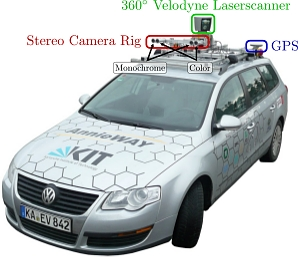

# Download & Install Datasets and Libraries

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip
    
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
    
!git clone https://github.com/ultralytics/yolov5
%pip install -r yolov5/requirements.txt 

!git clone https://github.com/nianticlabs/monodepth2.git
    
!git clone https://github.com/nianticlabs/manydepth.git
!wget https://storage.googleapis.com/niantic-lon-static/research/manydepth/models/KITTI_MR.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
fatal: destination path 'yolov5' already exists and is not an empty directory.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
fatal: destination path 'monodepth2' already exists and is not an empty directory.
fatal: destination path 'manydepth' already exists and is not an empty directory.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import zipfile
import os
import sys
from glob import glob

import cv2
import numpy as np
import pandas as pd

import torch
from torchvision import transforms

import matplotlib as mpl
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import PIL.Image as pil

# MONODEPTH
sys.path.append(r"C:\your\path\to\monodepth2")
from monodepth2.layers import ConvBlock
from monodepth2.layers import Conv3x3, disp_to_depth
from monodepth2.utils import download_model_if_doesnt_exist
from monodepth2.networks.depth_decoder import DepthDecoder
from monodepth2.networks.resnet_encoder import ResnetEncoder

# Manydepth
%pip install git+https://github.com/AdityaNG/manydepth@pip-module
import manydepth

from manydepth import networks
from manydepth.layers import transformation_from_parameters

# Extract Paths and Useful Parameters

In [3]:
with zipfile.ZipFile('2011_09_26_drive_0106_sync.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
    
data_path = 'data/2011_09_26/2011_09_26_drive_0106_sync'

with zipfile.ZipFile('2011_09_26_calib.zip', 'r') as zip_ref:
    zip_ref.extractall('calib')
    
calib_path = 'calib/2011_09_26/2011_09_26_drive_0106_sync'
    
with zipfile.ZipFile('KITTI_MR.zip', 'r') as zip_ref:
    zip_ref.extractall('manydepth_model_kitti_mr')

left_image_paths = sorted(glob(os.path.join(data_path, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(data_path, 'image_03/data/*.png')))
bin_paths = sorted(glob(os.path.join(data_path, 'velodyne_points/data/*.bin')))


with open('calib/2011_09_26/calib_cam_to_cam.txt','r') as f:
    cam_calib = f.readlines()
    
with open(r'calib/2011_09_26/calib_velo_to_cam.txt', 'r') as f:
    velo_calib = f.readlines()

P_left = np.array([float(x) for x in cam_calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in cam_calib[33].strip().split(' ')[1:]]).reshape((3,4))

R_left_rect = np.array([float(x) for x in cam_calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)

R_right_rect = np.array([float(x) for x in cam_calib[32].strip().split(' ')[1:]]).reshape((3, 3,))
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

R_cam_velo = np.array([float(x) for x in velo_calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_cam_velo = np.array([float(x) for x in velo_calib[2].strip().split(' ')[1:]])[:, None]
T_cam_velo = np.vstack((np.hstack((R_cam_velo, t_cam_velo)),np.array([0, 0, 0, 1])))

# Helper Functions

In [4]:
# Decompose the projection matrix P using OpenCV's decomposeProjectionMatrix function.
# This splits P into several components, but we are primarily interested in:
# - K: the intrinsic matrix, which contains camera-specific parameters (e.g., focal length, principal point).
# - R: the rotation matrix, which represents the camera's orientation relative to the scene.
# - T: the translation vector, which gives the camera's position in 3D space.

def decompose_projection_matrix(P):    
    K, R, T, _, _, _, _ = cv2.decomposeProjectionMatrix(P)
    T = T/T[3]

    return K, R, T

In [5]:
# Converts the LiDAR point cloud to camera (u, v, z) image coordinates, where z is in meters
def get_velo2cam(lidar_bin):
    
    # read in LiDAR data
    scan_data = np.fromfile(lidar_bin, dtype=np.float32).reshape((-1,4))

    # convert to homogeneous coordinate system
    velo_points = scan_data[:, 0:3] # (x, y, z) --> (front, left, up)
    velo_points = np.insert(velo_points, 3, 1, axis=1).T # homogeneous LiDAR points

    # delete negative liDAR points
    velo_points = np.delete(velo_points, np.where(velo_points[3, :] < 0), axis=1) 

    # convert to camera coordinates
    velo_camera = P_left @ R_left_rect @ T_cam_velo @ velo_points

    # delete negative camera points
    velo_camera  = np.delete(velo_camera , np.where(velo_camera [2,:] < 0)[0], axis=1) 

    # get camera coordinates u,v,z
    velo_camera[:2] /= velo_camera[2, :]

    return velo_camera

In [6]:
# Projects LiDAR point cloud onto the image coordinate frame
def project_velo2cam(lidar_bin, image):

    # get camera (u, v, z) coordinates
    velo_camera = get_velo2cam(lidar_bin)

    (u, v, z) = velo_camera

    # remove outliers (points outside of the image frame)
    img_h, img_w, _ = image.shape
    u_out = np.logical_or(u < 0, u > img_w)
    v_out = np.logical_or(v < 0, v > img_h)
    outlier = np.logical_or(u_out, v_out)
    velo_camera = np.delete(velo_camera, np.where(outlier), axis=1)
    
    return velo_camera

In [7]:
def load_and_preprocess_image(image_path, resize_width, resize_height):
    image = pil.open(image_path).convert('RGB')
    original_width, original_height = image.size
    image = image.resize((resize_width, resize_height), pil.LANCZOS)
    image = transforms.ToTensor()(image).unsqueeze(0)
    if torch.cuda.is_available():
        return image.cuda(), (original_height, original_width)
    return image, (original_height, original_width)

In [8]:
def load_and_preprocess_intrinsics(K_inp, resize_width, resize_height):
    K = np.eye(4)
    K[:3, :3] = K_inp

    # Convert normalised intrinsics to 1/4 size unnormalised intrinsics.
    # (The cost volume construction expects the intrinsics corresponding to 1/4 size images)
    K[0, :] *= resize_width // 4
    K[1, :] *= resize_height // 4

    invK = torch.Tensor(np.linalg.pinv(K)).unsqueeze(0)
    K = torch.Tensor(K).unsqueeze(0)

    if torch.cuda.is_available():
        return K.cuda(), invK.cuda()
    else:
        return K, invK

# 1. View Left and Right Images & Comment on Disparity.

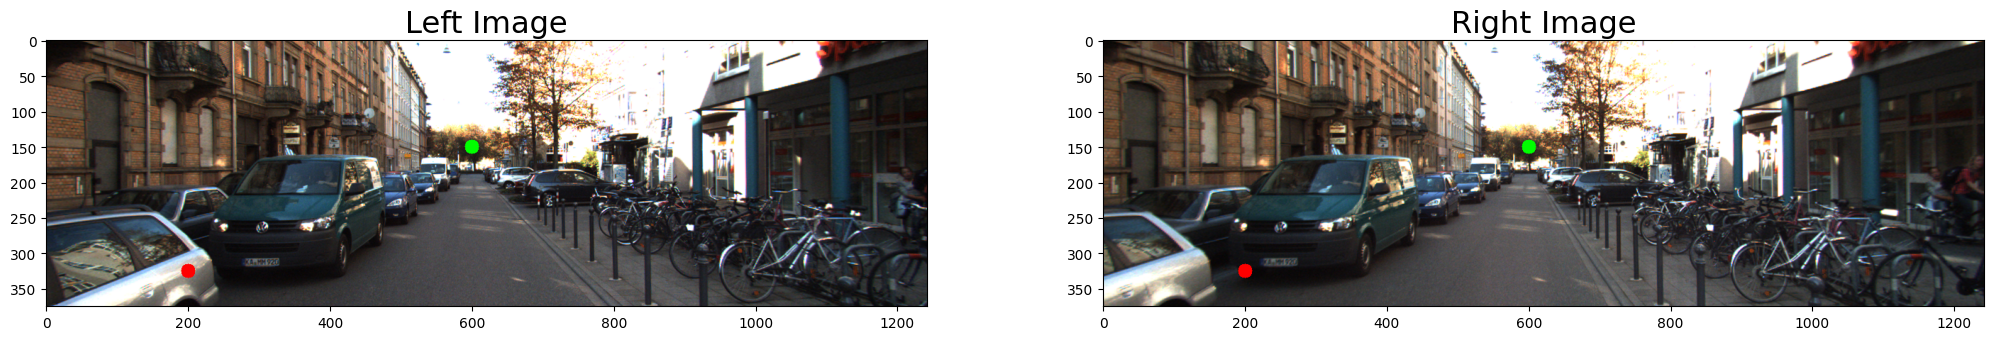

In [9]:
img_index = 80

left_image = cv2.cvtColor(cv2.imread(left_image_paths[img_index]), cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(cv2.imread(right_image_paths[img_index]), cv2.COLOR_BGR2RGB)

pt_1 = (200, 325)
pt_2 = (600, 150)

cv2.circle(left_image, pt_1, 10, [255, 0, 0], -1)
cv2.circle(right_image, pt_1, 10, [255, 0, 0], -1)
cv2.circle(left_image, pt_2, 10, [0, 255, 0], -1)
cv2.circle(right_image, pt_2, 10, [0, 255, 0], -1)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))
ax1.imshow(left_image)
ax1.set_title('Left Image', size=22)
ax2.imshow(right_image)
ax2.set_title('Right Image', size=22);

## Notice how the Red pt has a greater 'shift' than the green point.
## Comment on why this is and how it might effect depth estimation?
#### Answer: The red point has a greater shift than green due to its distance from the cameras. Points further away, like the green dot, cause less disparity between the camera perspectives. The disparity between an object in 2 stereo images is inversely proportional to the distance from the observer.

# 2. Generate Disparity Map thru' classical and DL approaches.

# 2a. Stereo Disparity Map.

In [10]:
def compute_sgbm_disparity(left_image, right_image, num_disparities, block_size, window_size):
    # Create a stereoSGBM object
    stereo = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=num_disparities,
        blockSize=block_size,
        P1=8 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
        )
        
    # Compute disparity map for the left and right images
    disparity = stereo.compute(left_image, right_image).astype(np.float32) / 16.0

    return disparity

# Use the function defined above and vary the 3 input parameters (num_disparities, block_size, window_size).

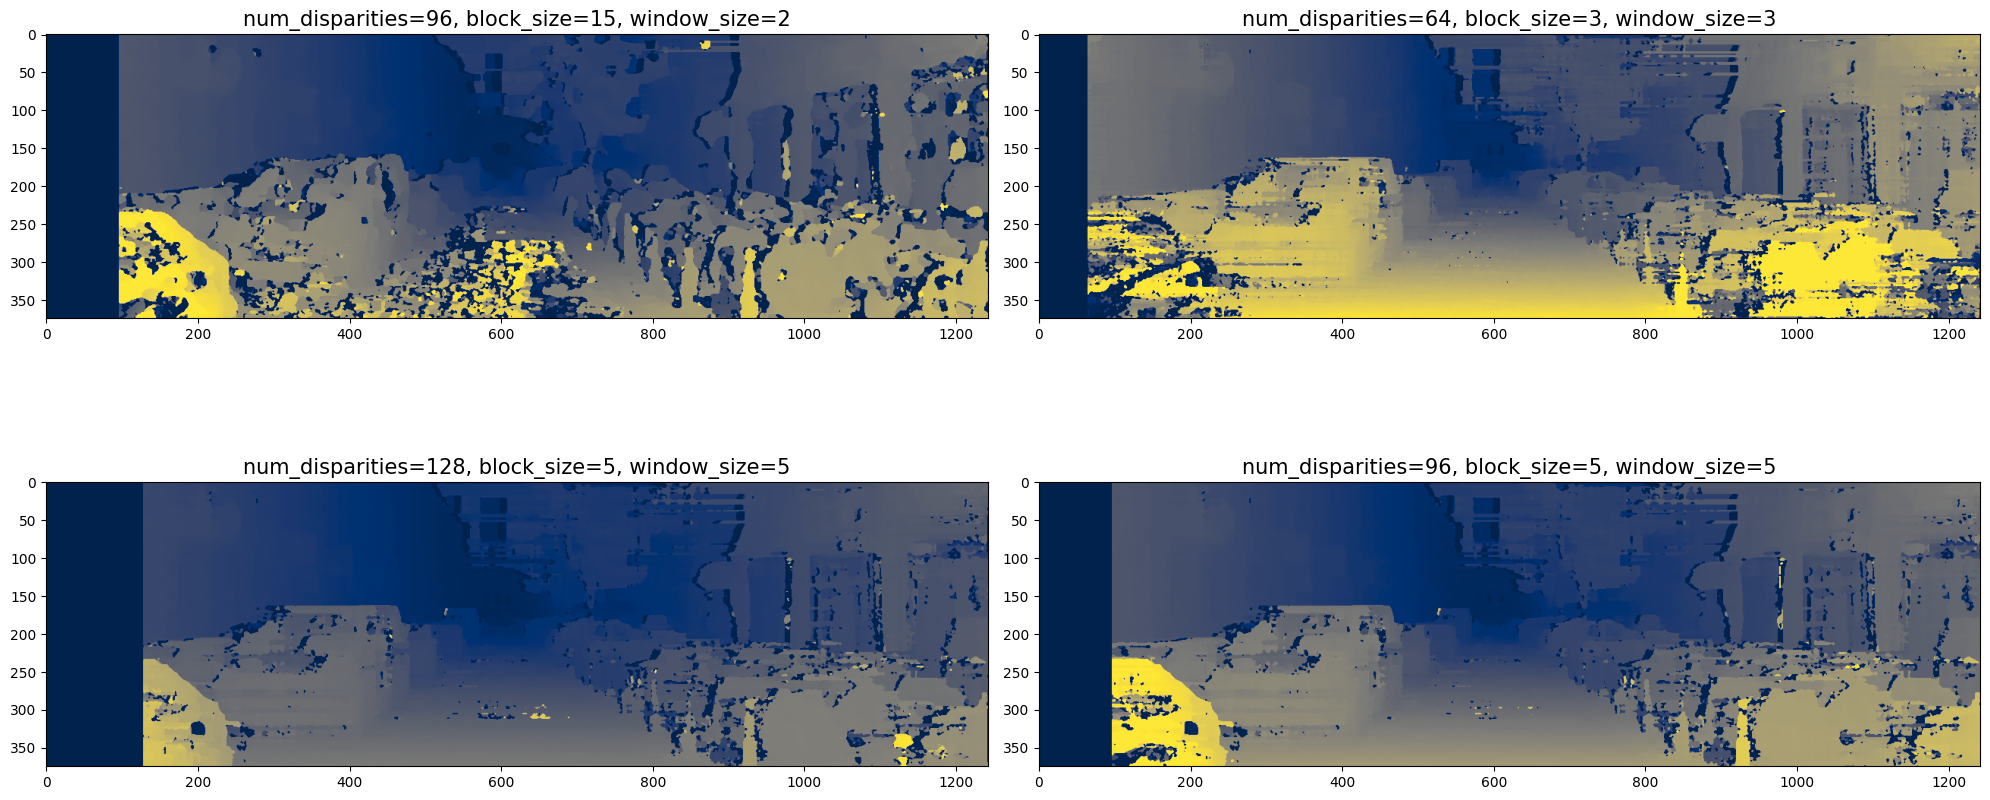

In [11]:
%matplotlib inline
left_image_gray = cv2.cvtColor(left_image, cv2.COLOR_RGB2GRAY)
right_image_gray = cv2.cvtColor(right_image, cv2.COLOR_RGB2GRAY)

# Initial values plus 3 other combinations
parameter_combinations = [
    (96, 15, 2),
    (64, 3, 3),
    (128, 5, 5),
    (96, 5, 5)
]

plt.figure(figsize=(20, 10))

for i, (num_disparities, block_size, window_size) in enumerate(parameter_combinations, 1):
    disparity_stereo = compute_sgbm_disparity(left_image_gray, right_image_gray, num_disparities, block_size, window_size)
    plt.subplot(2, 2, i)
    plt.imshow(disparity_stereo, cmap='cividis')
    plt.title(f'num_disparities={num_disparities}, block_size={block_size}, window_size={window_size}', size=15)

plt.tight_layout()
plt.show()

# What effect does num_disparities, block_size, and window_size have on the disparity map. How can you go about fixing the 'noise' in the image?
# Answer: 
#### The "num_disparities" determines the max disparity value. Higher values allow a larger range of depth values to be computed in the disparity map, but higher values also increase computational complexity. 
#### "block_size" defines the size of window used for matching the pixels in the left/right images. Larger block sizes give more accurate disparity values but increase computational complexity. 
#### The "window_size" determines the size of the correlation window used in matching. Higher values have higher computation cost. 

# 2b. Monodepth. Mono Trained.

In [12]:
model_name = "mono_640x192"
download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = ResnetEncoder(18, False)
depth_decoder = DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))
loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)
loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)
encoder.eval()
depth_decoder.eval();

c:\Users\suder\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\suder\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


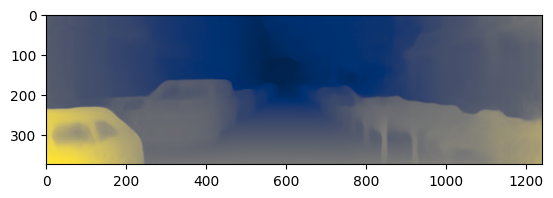

In [13]:
image_path = left_image_paths[img_index]
resize_height = loaded_dict_enc['height']
resize_width = loaded_dict_enc['width']
image, original_size = load_and_preprocess_image(image_path, resize_width, resize_height)

with torch.no_grad():
    features = encoder(image)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]
disp_resized = torch.nn.functional.interpolate(disp, original_size, mode="bilinear", align_corners=False)
disp_resized_np = disp_resized.squeeze().cpu().numpy()
disparity_map_monodepth_1 = disp_resized_np
plt.imshow(disparity_map_monodepth_1, cmap='cividis')

# 2c. Monodepth. Mono+Stereo Trained.

In [14]:
model_name = "mono+stereo_640x192"
download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = ResnetEncoder(18, False)
depth_decoder = DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))
loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)
loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)
encoder.eval()
depth_decoder.eval();

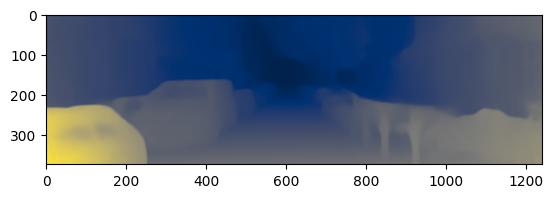

In [15]:
image_path = left_image_paths[img_index]
resize_height = loaded_dict_enc['height']
resize_width = loaded_dict_enc['width']
image, original_size = load_and_preprocess_image(image_path, resize_width, resize_height)

with torch.no_grad():
    features = encoder(image)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]
disp_resized = torch.nn.functional.interpolate(disp, original_size, mode="bilinear", align_corners=False)
disp_resized_np = disp_resized.squeeze().cpu().numpy()
disparity_map_monodepth_2 = disp_resized_np
plt.imshow(disparity_map_monodepth_2, cmap='cividis')

# 2d. Manydepth

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
path_model = 'manydepth_model_kitti_mr/KITTI_MR'
encoder_dict = torch.load(os.path.join(path_model, "encoder.pth"), map_location=device)

In [17]:
## WORKING VERSION.

# Loading pretrained model
print("Loading pretrained encoder")
encoder_dict = torch.load(os.path.join(path_model, "encoder.pth"), map_location=device)
encoder = networks.ResnetEncoderMatching(18, False,
                                             input_width=encoder_dict['width'],
                                             input_height=encoder_dict['height'],
                                             adaptive_bins=True,
                                             min_depth_bin=encoder_dict['min_depth_bin'],
                                             max_depth_bin=encoder_dict['max_depth_bin'],
                                             depth_binning='linear',
                                             num_depth_bins=96)

filtered_dict_enc = {k: v for k, v in encoder_dict.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

print("Loading pretrained decoder")
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict = torch.load(os.path.join(path_model, "depth.pth"), map_location=device)
depth_decoder.load_state_dict(loaded_dict)

print("Loading pose network")
pose_enc_dict = torch.load(os.path.join(path_model, "pose_encoder.pth"),
                               map_location=device)
pose_dec_dict = torch.load(os.path.join(path_model, "pose.pth"), map_location=device)

pose_enc = networks.ResnetEncoder(18, False, num_input_images=2)
pose_dec = networks.PoseDecoder(pose_enc.num_ch_enc, num_input_features=1,
                                    num_frames_to_predict_for=2)

pose_enc.load_state_dict(pose_enc_dict, strict=True)
pose_dec.load_state_dict(pose_dec_dict, strict=True)

# Setting states of networks
encoder.eval()
depth_decoder.eval()
pose_enc.eval()
pose_dec.eval()
if torch.cuda.is_available():
    encoder.cuda()
    depth_decoder.cuda()
    pose_enc.cuda()
    pose_dec.cuda()

Loading pretrained encoder
Loading pretrained decoder
Loading pose network


In [18]:
input_image, original_size = load_and_preprocess_image(left_image_paths[img_index],resize_width=encoder_dict['width'],resize_height=encoder_dict['height'])
source_image, _ = load_and_preprocess_image(left_image_paths[img_index-1], resize_width=encoder_dict['width'], resize_height=encoder_dict['height'])

K_left, R_left, T_left = decompose_projection_matrix(P_left)

resize_width=encoder_dict['width']
resize_height=encoder_dict['height']
K, invK = load_and_preprocess_intrinsics(K_left,resize_width,resize_height)

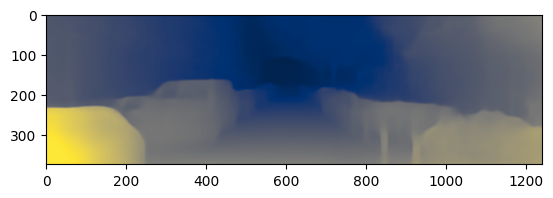

In [19]:
%matplotlib inline
with torch.no_grad():
    pose_inputs = [source_image, input_image]
    pose_inputs = [pose_enc(torch.cat(pose_inputs, 1))]
    axisangle, translation = pose_dec(pose_inputs)
    pose = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert=True)
    
    output, lowest_cost, _ = encoder(current_image=input_image,
                                        lookup_images=source_image.unsqueeze(1),
                                        poses=pose.unsqueeze(1),
                                        K=K,
                                        invK=invK,
                                        min_depth_bin=encoder_dict['min_depth_bin'],
                                        max_depth_bin=encoder_dict['max_depth_bin'])
    
    output = depth_decoder(output)
    sigmoid_output = output[("disp", 0)]
    sigmoid_output_resized = torch.nn.functional.interpolate(sigmoid_output, original_size, mode="bilinear", align_corners=False)
    sigmoid_output_resized = sigmoid_output_resized.cpu().numpy()[:, 0]
    disparity_map_manydepth = np.reshape(sigmoid_output_resized, (375, 1242))
    plt.imshow(disparity_map_manydepth, cmap='cividis')

# You have outputted a disparity map for the above 3 methods. Compare each and comment on the disparity map.

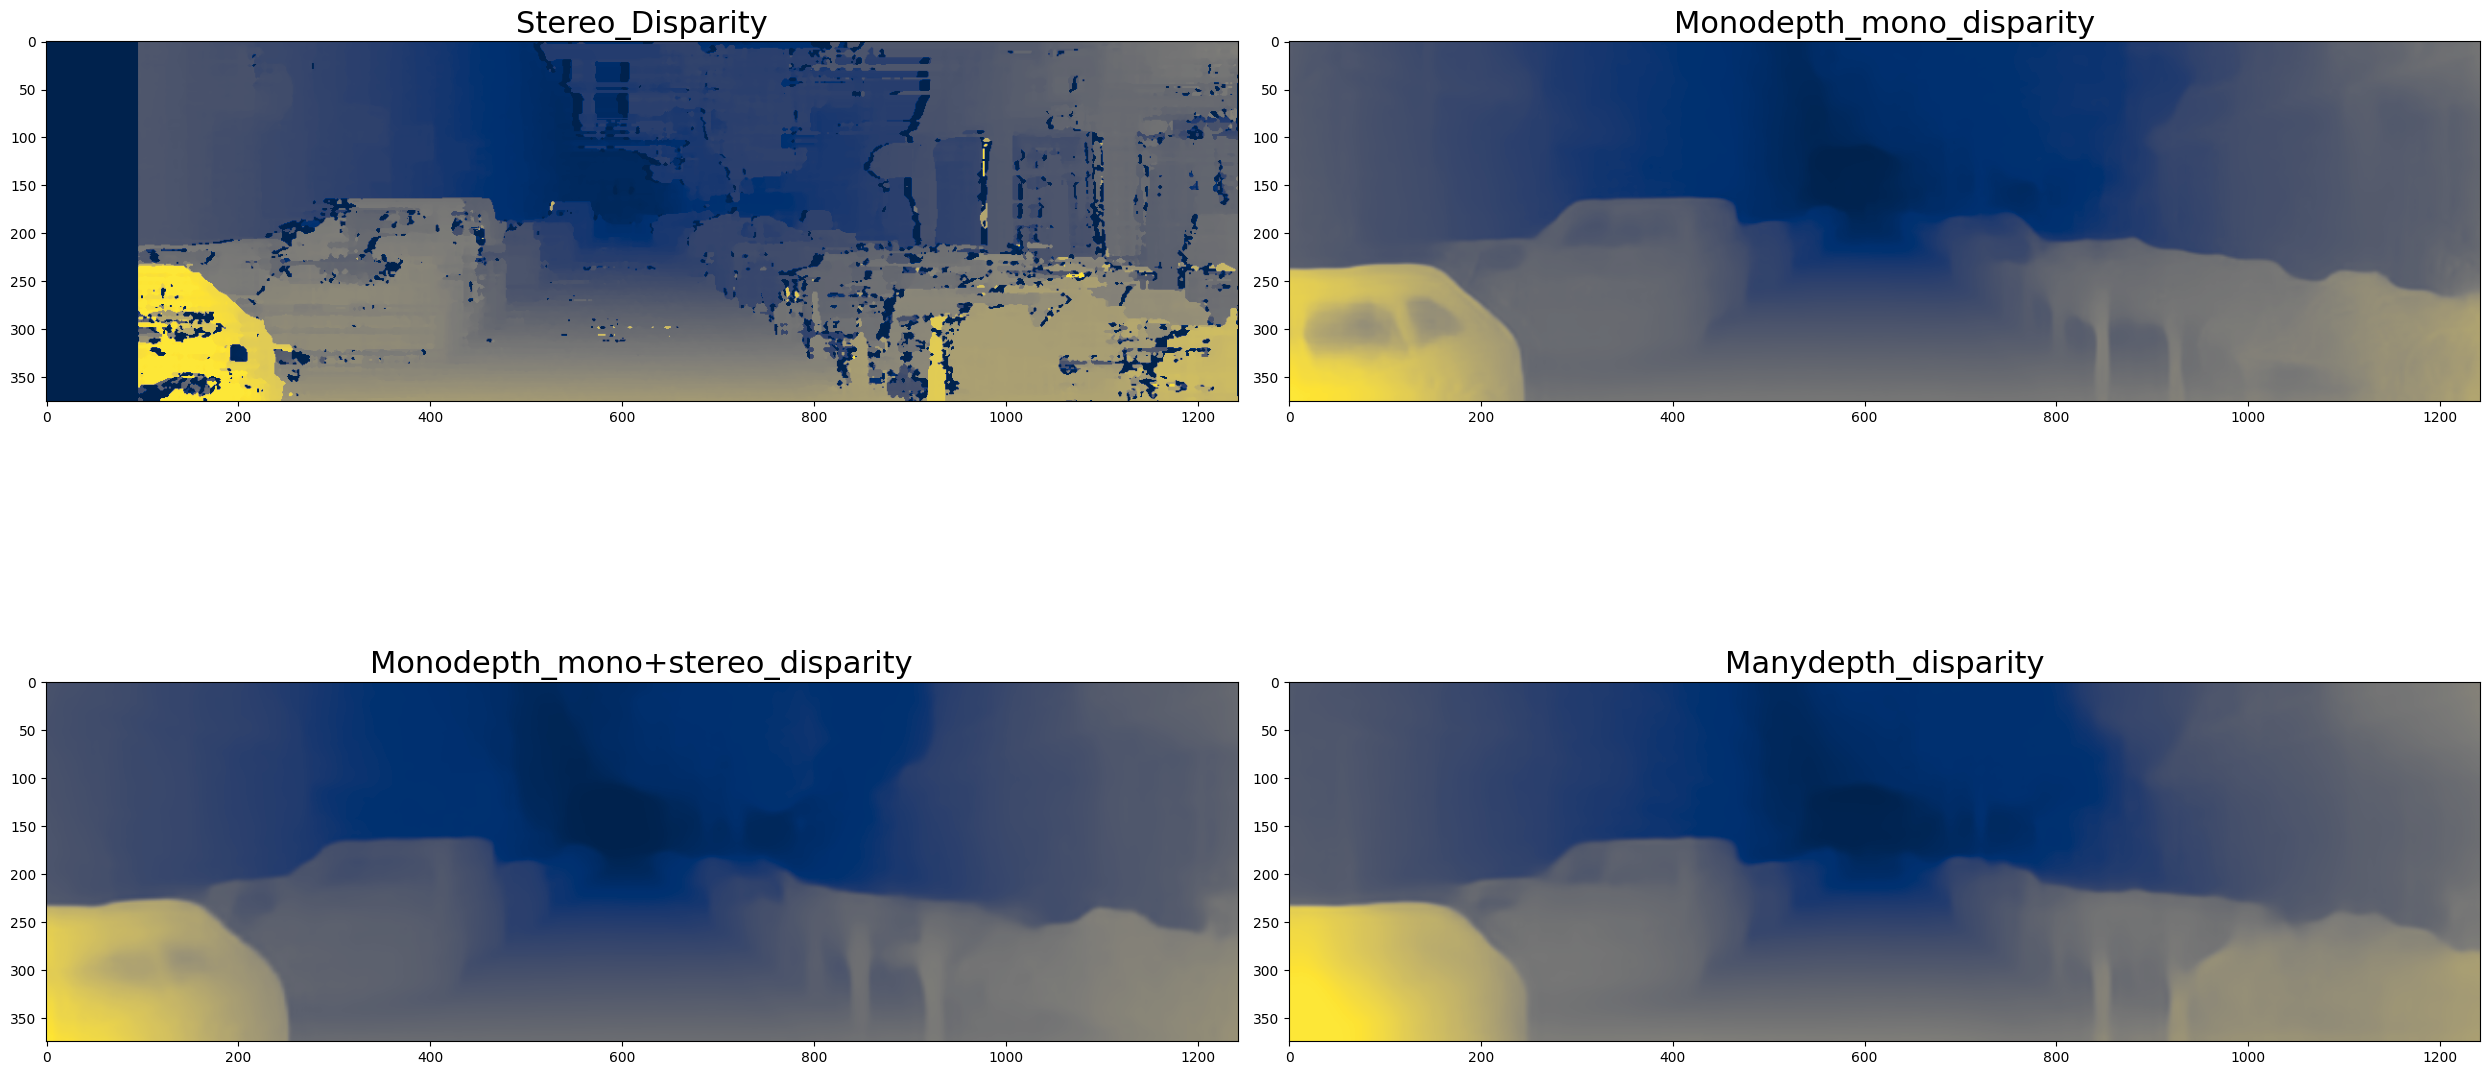

In [20]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15))

ax1.imshow(disparity_stereo, cmap='cividis')
ax1.set_title('Stereo_Disparity', size=22)

ax2.imshow(disparity_map_monodepth_1, cmap='cividis')
ax2.set_title('Monodepth_mono_disparity', size=22)

ax3.imshow(disparity_map_monodepth_2, cmap='cividis')
ax3.set_title('Monodepth_mono+stereo_disparity', size=22)

ax4.imshow(disparity_map_manydepth, cmap='cividis')
ax4.set_title('Manydepth_disparity', size=22)

plt.tight_layout()  # Adjust layout to prevent overlap if necessary
plt.show()

# Student's Answer: 

# You have outputted a disparity map for the above 3 methods. Compare each and comment on the disparity map.
#### Stereo Disparity generally seems to be the worst, with the disparity map being very noisy and not very clear. It is, however, very simple computationally and still able to identify key details like the van and vague shape of the bicycles.
#### Monodepth_mono plus stereo seems to be the best visually, with the disparity map being the most clear and having the least noise. Monodepth_mono is also very good and captures some details better, but does worse at estimating the dimensions of some objects since it has only one image perspective.
#### Monodepth_mono is also better as it is able to accurately give the distances of objects, due to having 2 images. Monodepth_mono has only one perspective and thus cannot give distances relative to the actual space, but can only provide a depth map of the information.   
#### Manydepth is the most computationally expensive but gives a very detailed disparity map. Dimensionally it is the most accurate, but does display significant noise. Depth is also harder to estimate visually off of the output image. 
#### Stereo disparity tends to produce noisy/unclear maps, and struggles with repetitive patterns/lack of texture. Monodepth_mono needs only a single image, but struggles with estimating the dimensions of objects andrelies on training data so might not be as accurate in all scenarios. Monodepth_mono plus stereo is more computationally expensive but gives slightly better results. Manydepth gives detailed maps but is the most expensive.



# 3. Generate Depth Map


# 3a. Stereo Pair Depth Map

In [21]:
import numpy as np
def calc_depth_map(disparity_left, intrinsic_left, T_left, T_right):
    # Compute the depth using this equation: Depth = (Focal_Length*Baseline)/Disparity_Left.
    # Inputs:
    # 1. disparity_left
    # 2. intrinsic_left
    # 3. T_left/_right - translation vector
    # Outputs:
    # 1. depth_map
    
    # Calculate the focal length from the intrinsic matrix
    focal_length = intrinsic_left[0, 0] # Focal length along x-axis
    
    # Calculate the baseline from the translation vectors
    baseline = np.linalg.norm(T_left - T_right)
    
    # Calculate the depth map using the disparity map
    depth_map = (focal_length * baseline) / disparity_left
    
    return depth_map
    

C:\Users\suder\AppData\Local\Temp\ipykernel_10272\1638264693.py:18: RuntimeWarning: divide by zero encountered in divide
  depth_map = (focal_length * baseline) / disparity_left
C:\Users\suder\AppData\Local\Temp\ipykernel_10272\4150050407.py:5: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(depth_map_stereo), cmap='viridis_r')


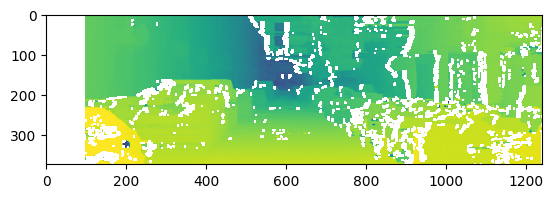

In [22]:
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

depth_map_stereo = calc_depth_map(disparity_stereo, K_left, T_left, T_right)
plt.imshow(np.log(depth_map_stereo), cmap='viridis_r')

# 3b. Monodepth

### Use disparity_map_monodepth_2 from 2c as your disparity map to calc depth. This is the disparity map with mono+stereo trained. Why wont it work with disparity_map_monodepth_1 (i.e. mono_trained)?

### Answer:
#### The mono_stereo trained disparity map will be more accurate because the mono+stereo model is trained on the image pairs and on single images, which helps it to learn more about the depth information in a scene.

In [23]:
scaled_depth_mondepth_2, depth_monodepth_2 = disp_to_depth(disparity_map_monodepth_2, 0.1, 100)
depth_monodepth_2 = torch.tensor(depth_monodepth_2)
metric_depth_monodepth_2 = 5.4*depth_monodepth_2
# plt.imshow(np.log(metric_depth_monodepth_2), cmap='viridis_r')

C:\Users\suder\AppData\Local\Temp\ipykernel_10272\3200601179.py:3: RuntimeWarning: invalid value encountered in log
  ax1.imshow(np.log(depth_map_stereo), cmap='viridis_r')


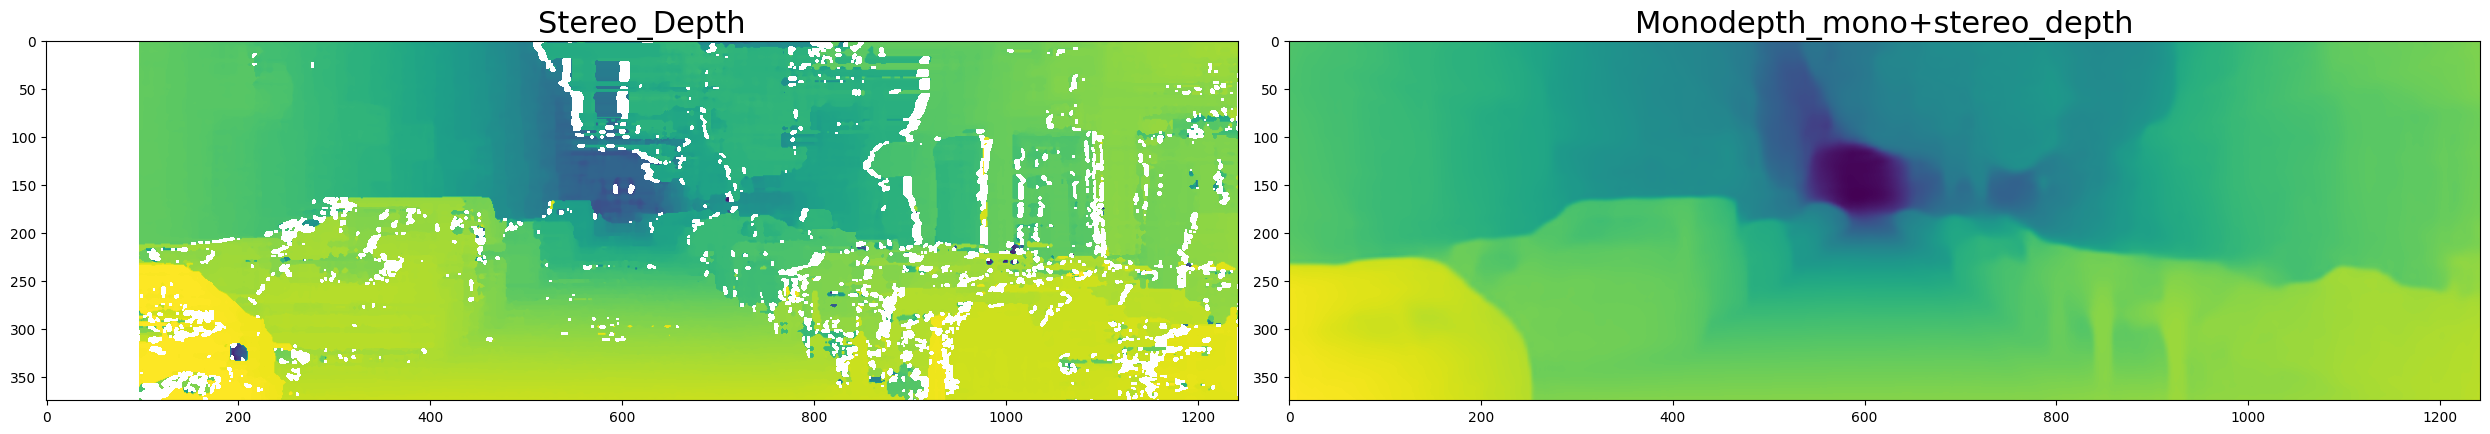

In [24]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(25, 15))

ax1.imshow(np.log(depth_map_stereo), cmap='viridis_r')
ax1.set_title('Stereo_Depth', size=22)

ax2.imshow(np.log(depth_monodepth_2), cmap='viridis_r')
ax2.set_title('Monodepth_mono+stereo_depth', size=22)

plt.tight_layout()  # Adjust layout to prevent overlap if necessary
plt.show()

# 4. Generate 2D Detections


Using cache found in C:\Users\suder/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-3-6 Python-3.12.0 torch-2.2.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


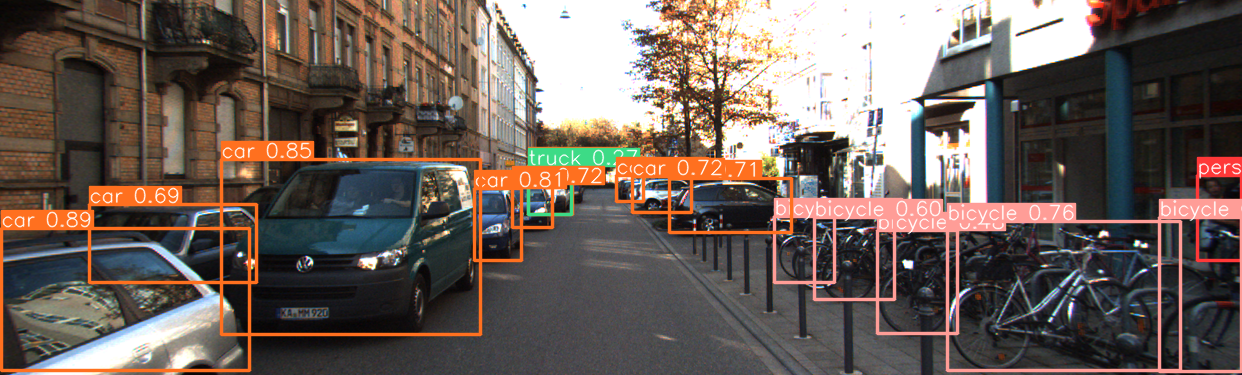

In [25]:
%matplotlib inline
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45
left_image = cv2.cvtColor(cv2.imread(left_image_paths[img_index]), cv2.COLOR_BGR2RGB)
# plt.imshow(left_image)

detections = model(left_image)
detections.show() # draw boxes on image
plt.imshow(left_image)

# 5. Get Distance from Depth Map and 2D Detection

In [26]:
def get_distances(image, depth_map, bboxes, draw, method):
    depth_arr = []
    stereo_depth = 0
    
    for bbox in bboxes:
        pt1 = (int(bbox[0]), int(bbox[1]))
        pt2 = (int(bbox[2]), int(bbox[3]))
        
        # Compute center location on image
        x_center = (pt1[0] + pt2[0]) // 2
        y_center = (pt1[1] + pt2[1]) // 2
        
        # Get depth slice
        depth_slice = depth_map[pt1[1]:pt2[1], pt1[0]:pt2[0]]
        
        if method == 'center':
            # Compute center depth
            depth_value = depth_slice[(y_center - pt1[1], x_center - pt1[0])]
            
            if depth_value > 0:
                print(depth_value)
                depth_arr.append(depth_value)
            else:
                depth_arr.append(0)
        else:
            # Compute median depth
            depth_value = np.median(depth_slice)
            if depth_value > 0:
                print(depth_value)
                depth_arr.append(depth_value)
            else:
                depth_arr.append(0)

    if draw:
        for depth_value, bbox in zip(depth_arr, bboxes):
            stereo_depth += depth_value
            pt1 = (int(bbox[0]), int(bbox[1]))
            pt2 = (int(bbox[2]), int(bbox[3]))

            cv2.rectangle(image, (pt1[0], pt1[1]), (pt2[0], pt2[1]), (252, 119, 30), 2)
            cv2.putText(image,'{0:.2f} m'.format(depth_value), (pt1[0], pt1[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2, cv2.LINE_AA)   
    
    return image, depth_arr


# Why won't Mean/Min/Max approach work well?
# Answer:
#### Mean depth value can be influenced by outliers and noise in the disparity map, and give innaccurate distance estimations. This is especially problematic in stereo where there is more occlusions and noise. 
#### Using the minimum depth value can cause underestimating the object distance, especially if the min distance is an outlier or bad estimation. 
#### The max depth value can cause overestimation of distance similar to minimum.

# Implement a median and centre approach. Explain why you chose this. 
# Answer: 
#### The median approach is robust because it is less affected by outliers, giving a more accurate estimation of depth values in the region of interest.
#### The center depth also gives a good approximation, similar to the median approach, but assumes that the center of the object is a good estimation of overall approximate distance. 

# Student's Answer:

# 6. Compare Median Distance vs Centre Distance.

In [27]:
img_index = 80
left_image = cv2.cvtColor(cv2.imread(left_image_paths[img_index]), cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(cv2.imread(right_image_paths[img_index]), cv2.COLOR_BGR2RGB)

bboxes = detections.xyxy[0]
median_image, depth_arr_median = get_distances(left_image.copy(), depth_map_stereo, bboxes, draw=True, method='median')
center_image, depth_arr_center = get_distances(left_image.copy(), depth_map_stereo, bboxes, draw=True, method='center')

4.046072
8.113496
15.375074
6.047227
35.14303
25.102163
21.428675
8.007852
5.3571687
10.4237795
7.3301907
10.96262
59.709026
9.549736
37.500183
37.500183
9.461584
14.963576
6.0058885
34.357708
25.308765
21.134123
8.344681
6.6486807
9.332367
7.3301907
53.47852
9.564588
37.500183
37.730244


In [28]:
# Plotting depth arrays
plt.figure(figsize=(25, 15))
plt.subplot(2, 1, 1)
plt.imshow(median_image)
plt.title('Stereo_Median', size=22)
plt.subplot(2, 1, 2)
plt.imshow(center_image)
plt.title('Stereo_Center', size=22)

# Remove ticks from the graph
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(depth_arr_median, label='Stereo_Median')
plt.plot(depth_arr_center, label='Stereo_Center')
plt.title('Distance from objects')
plt.xlabel('Object Index')
plt.ylabel('Distance (m)')
plt.legend()
plt.show()

# Comment on the difference between the two methods (median/center). Why do you think this is happening?
# Answer:
#### The median depth represents the middle value in the list of depth values within the bbox, while the center depth computes the depth at the center of the object's bounding box. The difference between the two methods is very small, with both having nearly similar outputs with slight variation on different objects. This makes sense as for objects with a large ranges of or uneven disparities, the placement of center vs. median point will change. There is an initial plot value of -24 due to the object in that region being outside of the view of one of the stereo cameras, and this was fixed by exluding any negative distance values from the calculation and appending 0 instead. 

# 7. Compare Estimated Depth to LiDAR Ground Truth Depth.

In [29]:
def get_lidar_gt(bboxes, velo_camera):
    # This function will get the distance from the LiDAR for the 2D Detection.

    gt_depth_lidar_arr = []
    
    # unpack LiDAR camera coordinates
    u, v, z = velo_camera

    for bbox in bboxes:
        # get pt1 (x1, y1) and pt2 (x2, y2) ... same as in def get_distances
        pt1 = (int(bbox[0]), int(bbox[1]))
        pt2 = (int(bbox[2]), int(bbox[3]))

        # get center location on image (y_center, x_center)
        y_center = int((pt1[1] + pt2[1])/2)
        x_center = int((pt1[0] + pt2[0])/2)
        
        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u))- np.array([[y_center, x_center]]).T)
        
        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        velo_depth = z[min_loc]
        gt_depth_lidar_arr.append(velo_depth)

    return gt_depth_lidar_arr

In [30]:
bboxes = detections.xyxy[0]
lidar_bin = bin_paths[img_index]
velo_camera = project_velo2cam(lidar_bin, left_image)

gt_depth_lidar_arr = get_lidar_gt(bboxes, velo_camera)

# 7a. Compare Stereo Pair against LiDAR Ground Truth.

In [31]:
bboxes = detections.xyxy[0]
left_image_stereo, depth_arr_stereo = get_distances(left_image, depth_map_stereo, bboxes, method='median', draw=True)
print(depth_arr_stereo)

4.046072
8.113496
15.375074
6.047227
35.14303
25.102163
21.428675
8.007852
5.3571687
10.4237795
7.3301907
10.96262
59.709026
9.549736
37.500183
37.500183
[4.046072, 8.113496, 15.375074, 6.047227, 35.14303, 25.102163, 21.428675, 8.007852, 5.3571687, 10.4237795, 7.3301907, 10.96262, 59.709026, 9.549736, 37.500183, 37.500183]


# 7b. Monodept (mono+stereo) vs LiDAR GT Depth Comparison

In [32]:
# Monodepth Stereo
# bboxes = detections.xyxy[0]
# left_image_stereo, depth_arr_stereo = get_distances(left_image, depth_map_stereo, bboxes, method='median', draw=True)
# print(depth_arr_stereo)

# Monodepth Mono + Stereo
bboxes = detections.xyxy[0]
left_image_monodepth, depth_arr_monodepth = get_distances(left_image, metric_depth_monodepth_2, bboxes, method='median', draw=True)
print(depth_arr_monodepth)

3.5602252
8.207351
15.0770235
5.4186373
30.314068
23.19398
17.430624
7.09272
4.70449
7.0520983
6.2789536
7.807116
56.196983
6.7637887
32.022156
32.39672
[3.5602252, 8.207351, 15.0770235, 5.4186373, 30.314068, 23.19398, 17.430624, 7.09272, 4.70449, 7.0520983, 6.2789536, 7.807116, 56.196983, 6.7637887, 32.022156, 32.39672]


# 7c. Compare the depth_arr_monodepth, depth_arr_stereo, and gt_depth_lidar_arr. Plot the values and comment on the differences.

[4.046072, 8.113496, 15.375074, 6.047227, 35.14303, 25.102163, 21.428675, 8.007852, 5.3571687, 10.4237795, 7.3301907, 10.96262, 59.709026, 9.549736, 37.500183, 37.500183]


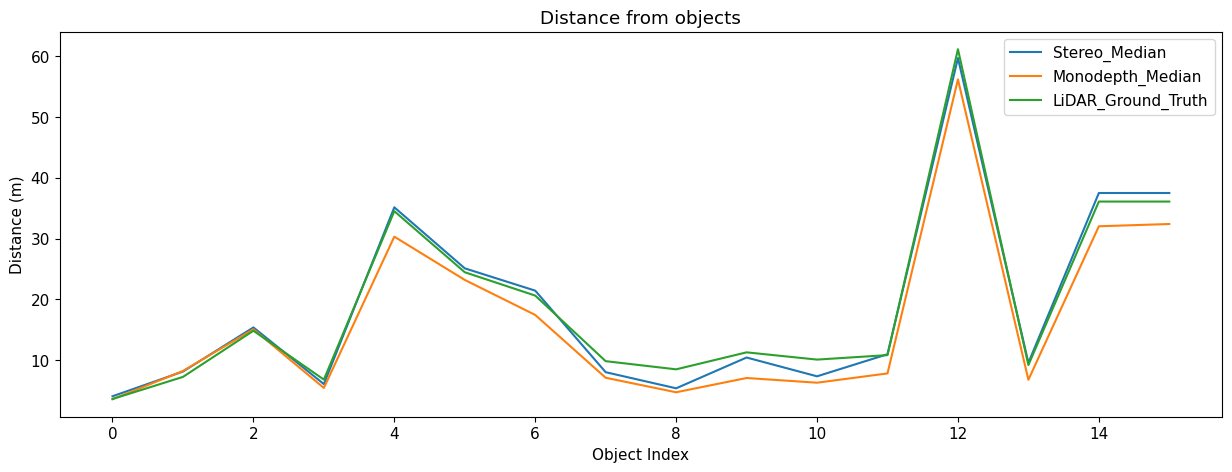

In [35]:
%matplotlib inline
# Plot values from depth_arr_monodepth, depth_arr_stereo, & gt_depth_lidar_arr
plt.figure(figsize=(15, 5))
plt.plot(depth_arr_stereo, label='Stereo_Median')
print(depth_arr_stereo)
plt.plot(depth_arr_monodepth, label='Monodepth_Median')
plt.plot(gt_depth_lidar_arr, label='LiDAR_Ground_Truth')
plt.title('Distance from objects')
plt.xlabel('Object Index')
plt.ylabel('Distance (m)')
plt.legend()
plt.show()


## Comments
#### The values plotted are relatively close, with Monodepth_Median being farther from the ground truth than Stereo_median. This makes sense, as with stereo images the distance estimation will always be more accurate than estimations using deep learning models. The GT is further away than estimated for indexes 7-11, which is likely due to objects which have more occlusion, or varied/low luminance. 

# 8. Extra Credit

### 1. Run MonoDepth and Stereo Depth Estimation for frames - IMG_80 to IMG_220. 
### 2. Get the error between the two methods and the LiDAR GT.
### 2a. Outline specific scenarios where the errors are high.

### 3. Comment on the overall errors.

Using cache found in C:\Users\suder/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-3-6 Python-3.12.0 torch-2.2.1+cpu CPU



Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


4.046072
8.113496
15.375074
6.047227
35.14303
25.102163
21.428675
8.007852
5.3571687
10.4237795
7.3301907
10.96262
59.709026
9.549736
37.500183
37.500183
3.5602252
8.207351
15.0770235
5.4186373
30.314068
23.19398
17.430624
7.09272
4.70449
7.0520983
6.2789536
7.807116
56.196983
6.7637887
32.022156
32.39672
14.927257
8.007852
4.046072
21.35427
24.212715
34.94335
6.035358
6.0711055
10.388564
37.272907
10.943113
7.4096746
37.272907
64.06281
43.007202
14.742989
7.9570208
3.8230562
17.543037
21.961304
29.670351
5.136154
5.8161774
7.0724325
31.347492
7.769369
6.581006
31.473526
63.082336
39.728844
7.775006
14.71299
24.023554
21.35427
34.94335
6.0711055
10.406142
6.0235357
37.272907
7.382989
11.625765
37.272907
38.437687
62.43846
7.5996976
14.42086
3.4265094
20.923252
16.590721
29.728783
4.8852506
7.130341
2.8458753
5.607945
31.738628
6.711185
8.115325
31.534897
35.95742
60.16162
7.4455566
11.759139
23.473396
21.35427
34.94335
9.179149
5.5960236
6.0711055
6.514862
36.826527
38.437687
37.04837


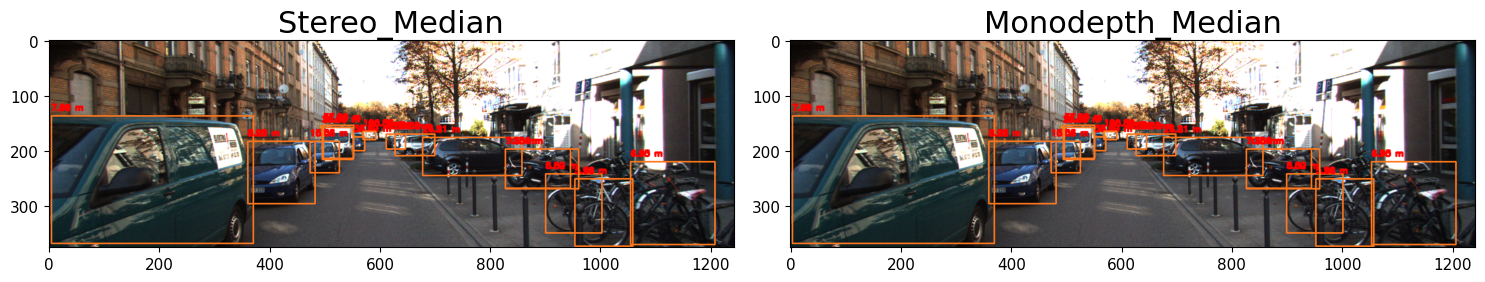

[7.0125766, 8.221965, 16.05752, 21.206999, 35.549305, 37.500183, 6.10122, 6.0176415, 10.441477, 36.826527, 5.994181, 38.198944, 180.88322, 73.21464, 10.258606]


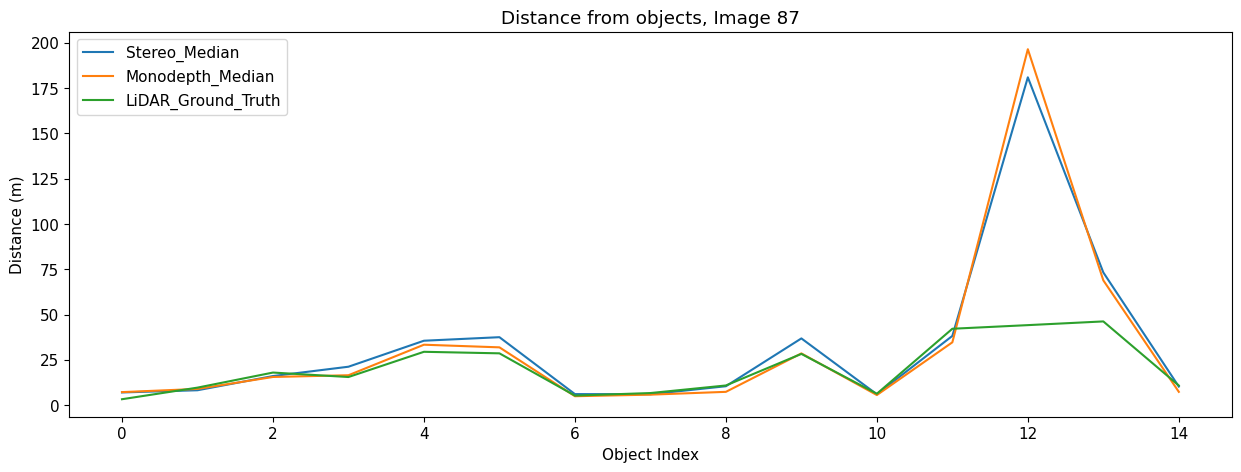

6.6630874
8.124214
15.375074
20.230362
35.14303
37.04837
6.0235357
37.04837
5.6318955
9.332367
180.88322
37.963146
91.79149
9.34655
6.000029
7.144745
8.37094
15.114971
14.600035
30.986603
29.79821
5.1980104
29.658552
4.6700535
7.329079
183.35706
34.10105
74.11521
7.1665983
5.6815424
7.956054
15.147857
20.230362
36.937447
34.357708
8.367388
4.259023
8.69877
5.2207384
60.29441
6.2247267
26.394978
175.71513
8.017138
14.883888
14.7603
28.49228
27.529812
8.2349415
7.0064063
7.113961
4.657279
56.28836
5.3976946
26.368477
164.56052
7.6683664
14.504787
18.035278
29.710289
7.490901
25.625124
6.156186
8.070906
56.42229
175.71513
37.846695
4.046072
4.046072
7.6192274
13.979158
13.632824
26.050499
7.3085766
24.883097
5.0808334
7.7629995
52.75331
135.65903
33.302025
4.1498837
4.1191397
12.2267
17.672499
7.2609563
7.4726973
6.1194324
7.3040733
25.518795
28.018505
55.909363
37.730244
175.71513
12.569672
13.673422
6.832248
7.3039904
4.880377
6.4379835
23.908283
25.560692
3.6159735
51.913063
3.6301262


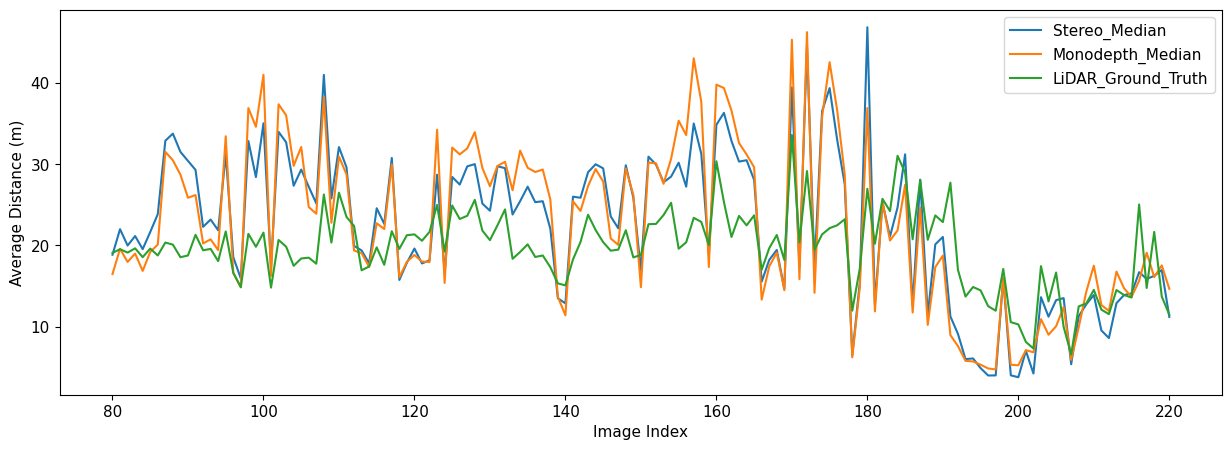

In [49]:
%matplotlib inline
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

depth_arr_stereo_avg = []
depth_arr_monodepth_avg = []
gt_depth_lidar_arr_avg = []

def run_depth_estimation(img_index):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[img_index]), cv2.COLOR_BGR2RGB)

    detections = model(left_image)
    
    # Monodepth Stereo
    bboxes = detections.xyxy[0]
    left_image_stereo, depth_arr_stereo = get_distances(left_image, depth_map_stereo, bboxes, method='median', draw=True)

    # Monodepth Mono + Stereo
    bboxes = detections.xyxy[0]
    left_image_monodepth, depth_arr_monodepth = get_distances(left_image, metric_depth_monodepth_2, bboxes, method='median', draw=True)

    # LiDAR Ground Truth
    lidar_bin = bin_paths[img_index]
    velo_camera = project_velo2cam(lidar_bin, left_image)
    gt_depth_lidar_arr = get_lidar_gt(bboxes, velo_camera)

    # Average of the depth arrays
    # print('Average of depth_arr_stereo:', np.mean(depth_arr_stereo))
    # print('Average of depth_arr_monodepth:', np.mean(depth_arr_monodepth))
    # print('Average of gt_depth_lidar_arr:', np.mean(gt_depth_lidar_arr))

    # Add average values to an array
    depth_arr_stereo_avg.append(np.mean(depth_arr_stereo))
    depth_arr_monodepth_avg.append(np.mean(depth_arr_monodepth))
    gt_depth_lidar_arr_avg.append(np.mean(gt_depth_lidar_arr))

    # If the image index is n, plot left_image_stereo and left_image_monodepth for comparison in the same figure
    if img_index == 87:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(left_image_stereo)
        plt.title('Stereo_Median', size=22)
        plt.subplot(1, 2, 2)
        plt.imshow(left_image_monodepth)
        plt.title('Monodepth_Median', size=22)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15, 5))
        plt.plot(depth_arr_stereo, label='Stereo_Median')
        print(depth_arr_stereo)
        plt.plot(depth_arr_monodepth, label='Monodepth_Median')
        plt.plot(gt_depth_lidar_arr, label='LiDAR_Ground_Truth')
        plt.title('Distance from objects, Image 87')
        plt.xlabel('Object Index')
        plt.ylabel('Distance (m)')
        plt.legend()
        plt.show()


index_start = 80
index_end = 221
# Loop through the frames from IMG_80 to IMG_220
for index in range(index_start, index_end):
    run_depth_estimation(index)

plt.figure(figsize=(15, 5))
plt.plot(range(index_start, index_end), depth_arr_stereo_avg, label='Stereo_Median')
plt.plot(range(index_start, index_end), depth_arr_monodepth_avg, label='Monodepth_Median')
plt.plot(range(index_start, index_end), gt_depth_lidar_arr_avg, label='LiDAR_Ground_Truth')
plt.xlabel('Image Index')
plt.ylabel('Average Distance (m)')
plt.legend()
plt.show()

## Comments
To calculate the error between the two methods and the LiDAR ground truth, the average distance of each image was taken and plotted against the GT. Many of the average distances are relatively similar, having an error of only 1-5 meters, while other images, such as around image 87, have larger discrepancies between 10-20 meters. Examining image 87 (plotted above), its seen that the main cause of this is an object detection by the model which is significantly further than the LiDAR GT is able to reach, being predicted at ~186m away. This detection is likely incorrect, due to low confidence and IoU thresholds, and skews some of the data. This could potentially be fixed by altering conf/IoU values or setting an upper limit on the range objects are detectable at which is the same as the LiDAR. Overall, using a model for depth estimation is fairly accurate but generally estimates distances further than the LiDAR gt, and should be calibrated for specific scenarios to remove any significant outliers in the data. 